In [1]:
# %%
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from torch.distributions import MultivariateNormal
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

base_dir = os.getcwd()

# ─────────────────────────────────────────────────────────────
# 1) Load and Prepare Data
# ─────────────────────────────────────────────────────────────
torch.manual_seed(1010)
np.random.seed(627)

Y21_np = np.array([16, 215, 362, 97, 76, 62, 710, 56, 133, 28, 62, 413, 194]).reshape(1, -1)
Y22_np = np.array([26983, 250930, 829348, 157775, 150467, 352445, 553066, 26751, 75815, 150302, 354993, 3683043, 507218]).reshape(1, -1)

Y21 = torch.tensor(Y21_np, dtype=torch.float32)
Y22 = torch.tensor(Y22_np, dtype=torch.float32) / 1000  

theta1_path = os.path.join(base_dir, "upstream", "theta1_samples.mat")
data = loadmat(theta1_path)
theta1_samples = torch.tensor(data['theta1'], dtype=torch.float32)
n_samples, latent_dim = theta1_samples.shape  

Y21 = Y21.repeat(n_samples, 1)  
Y22 = Y22.repeat(n_samples, 1)

data_D2 = {
    "Y21": Y21,
    "Y22": Y22
}

# ─────────────────────────────────────────────────────────────
# 2) Define Prior and Likelihood Functions
# ─────────────────────────────────────────────────────────────
def prior_log_prob_fn(theta2):
    """
    Prior: Multivariate Normal N(0, 1000*I)
    """
    prior_std = torch.sqrt(torch.tensor(1000.0))
    prior = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2) * prior_std**2)
    return prior.log_prob(theta2)

def likelihood_log_prob_fn(theta2, theta1, data):
    """
    log p(Y21 | theta2, theta1) where
    Y21 ~ Poisson(exp(beta + gamma * theta1))
    """
    Y21, Y22 = data["Y21"], data["Y22"]

    beta = theta2[:, 0:1]   
    gamma = theta2[:, 1:2]  
    linear_predictor = beta + gamma * theta1  
    poisson_lambda = torch.exp(linear_predictor) 

    log_likelihood = Y21 * linear_predictor - Y22 * poisson_lambda - torch.lgamma(Y21 + 1)
    return log_likelihood.sum(dim=1)  

# ─────────────────────────────────────────────────────────────
# 3) Initialize NeVI-Cut Model
# ─────────────────────────────────────────────────────────────
model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=latent_dim,
    theta_dim=2,  
    num_layers=2,
    hidden_features=64,
    num_bins=30,
    tail_bound=35.0
)

# ─────────────────────────────────────────────────────────────
# 4) Train the Model
# ─────────────────────────────────────────────────────────────
print("Training NeVI-Cut on HPV real data...")

loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=theta1_samples,
    data_D2=data_D2,  
    epochs=5000,
    lr=0.0015,
    patience=500,
    seed=404,
    log_interval=200  
)

print(f"Training completed")


Training NeVI-Cut on HPV real data...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 208330.062500 | LR: 1.50e-03
Step   200 | Loss: 15884.348633 | LR: 1.50e-03
Step   400 | Loss: 15884.570312 | LR: 1.50e-03
Step   600 | Loss: 15865.190430 | LR: 1.50e-03
Step   800 | Loss: 15868.603516 | LR: 1.50e-03
Step  1000 | Loss: 15865.438477 | LR: 1.50e-03
Epoch 01105: reducing learning rate of group 0 to 7.5000e-04.
Step  1200 | Loss: 15864.737305 | LR: 7.50e-04
Step  1400 | Loss: 15862.412109 | LR: 7.50e-04
Step  1600 | Loss: 15862.710938 | LR: 7.50e-04
Epoch 01672: reducing learning rate of group 0 to 3.7500e-04.
Step  1800 | Loss: 15860.998047 | LR: 3.75e-04
Step  2000 | Loss: 15860.486328 | LR: 3.75e-04
Step  2200 | Loss: 15863.799805 | LR: 3.75e-04
Epoch 02337: reducing learning rate of group 0 to 1.8750e-04.
Step  2400 | Loss: 15859.901367 | LR: 1.88e-04
Step  2600 | Loss: 15860.007812 | LR: 1.88e-04
Step  2800 | Loss: 15860.201172 | LR: 1.88e-04
Epoch 02838: reducing learnin

Text(0, 0.5, 'Loss')

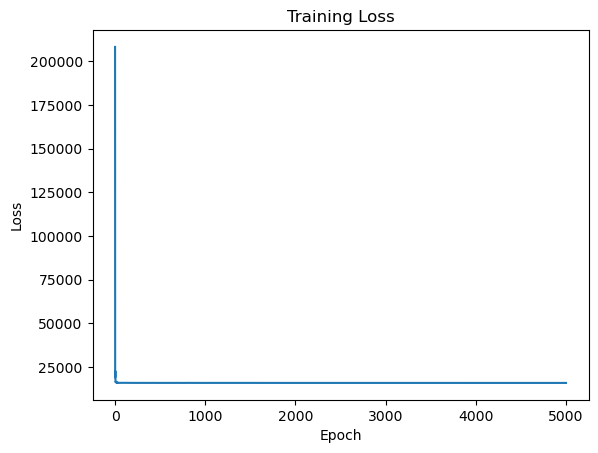

In [2]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Generated 100/100 samples


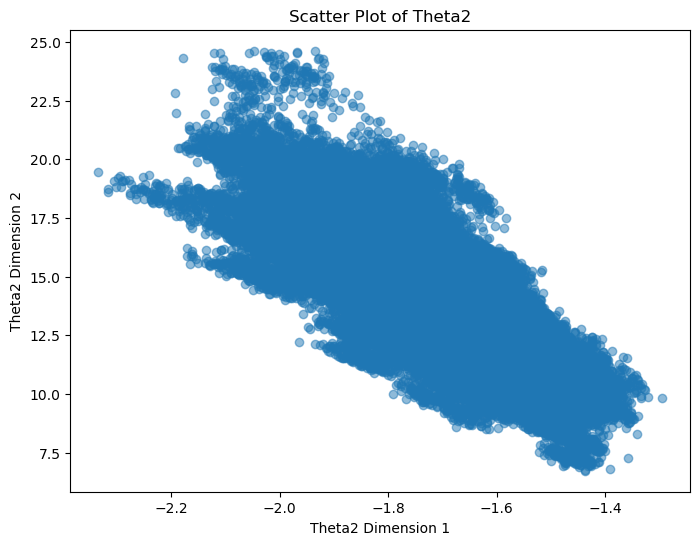

In [3]:
# ─────────────────────────────────────────────────────────────
# 5) Post-Training Sampling
# ─────────────────────────────────────────────────────────────
n_iterations = 100
theta2_samples = get_marginal_samples(model, theta1_samples, n_iterations=n_iterations)
theta2_samples_flat = theta2_samples.cpu().reshape(-1, 2).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(theta2_samples_flat[:, 0], theta2_samples_flat[:, 1], alpha=0.5)
plt.xlabel('Theta2 Dimension 1')
plt.ylabel('Theta2 Dimension 2')
plt.title('Scatter Plot of Theta2')
plt.show()


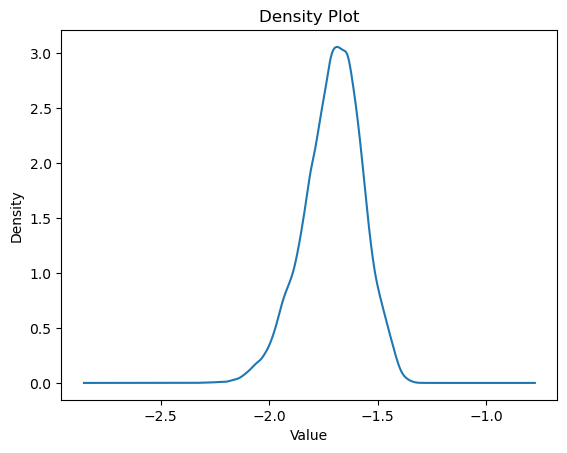

In [4]:
import pandas as pd
theta_series = pd.Series(theta2_samples_flat[:, 0])
theta_series.plot.kde()
plt.title("Density Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

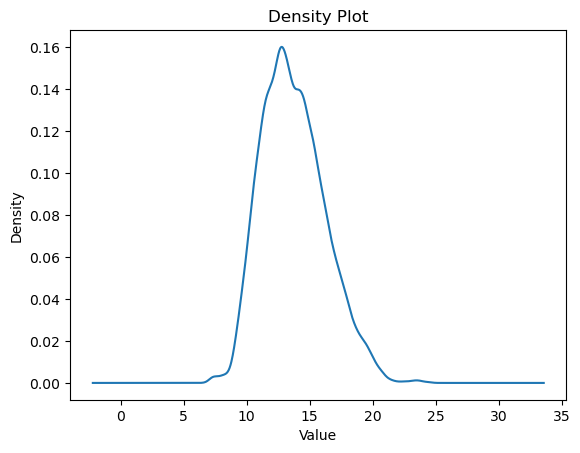

In [5]:
theta_series = pd.Series(theta2_samples_flat[:, 1])
theta_series.plot.kde()
plt.title("Density Plot")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()